# SageMaker - Batch Transform - PCA - Using Notebook

**Setup**

In [1]:
import sagemaker

sess = sagemaker.Session()

bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-batch-transform"

role = sagemaker.get_execution_role()

In [2]:
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.transformer import Transformer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.sparse
import os
import json

**Data**

In [3]:
!mkdir /tmp/reviews/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz /tmp/reviews/

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz to ../../../../tmp/reviews/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz


In [4]:
df = pd.read_csv("/tmp/reviews/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz", delimiter="\t", error_bad_lines=False)
df.head()

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


To keep the problem tractable and get started on batch transform quickly, we’ll make a few simplifying transformations on the data. Let’s start by reducing our dataset to users, items, and start ratings. We’ll keep product title on the dataset for evaluating our clustering at the end.

In [5]:
df = df[["customer_id", "product_id", "star_rating", "product_title"]]

Now, because most users don’t rate most products, and there’s a long tail of products that are almost never rated, we’ll tabulate common percentile

In [6]:
customers = df["customer_id"].value_counts()
products = df["product_id"].value_counts()

quantiles = [
    0,
    0.1,
    0.25,
    0.5,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.96,
    0.97,
    0.98,
    0.99,
    0.995,
    0.999,
    0.9999,
    1,
]
print("customers\n", customers.quantile(quantiles))
print("products\n", products.quantile(quantiles))

customers
 0.0000       1.0
0.1000       1.0
0.2500       1.0
0.5000       1.0
0.7500       2.0
0.8000       2.0
0.8500       3.0
0.9000       4.0
0.9500       5.0
0.9600       6.0
0.9700       7.0
0.9800       9.0
0.9900      13.0
0.9950      18.0
0.9990      37.0
0.9999      97.0
1.0000    2704.0
Name: customer_id, dtype: float64
products
 0.0000        1.000
0.1000        1.000
0.2500        1.000
0.5000        3.000
0.7500        9.000
0.8000       12.000
0.8500       18.000
0.9000       31.000
0.9500       73.000
0.9600       95.000
0.9700      130.000
0.9800      199.000
0.9900      386.670
0.9950      699.000
0.9990     1993.901
0.9999     7522.637
1.0000    32790.000
Name: product_id, dtype: float64


As we can see, only 0.1% of users have rated more than 36 movies. And, only 25% of movies have been rated more than 8 times. For the purposes of our analysis, we’d like to keep a large sample of popular movies for our clustering, but base that only on heavy reviewers. So, we’ll limit to customers who have reviewed 35+ movies and movies that have been reviewed 20+ times.

In [7]:
customers = customers[customers >= 35]
products = products[products >= 20]

reduced_df = df.merge(pd.DataFrame({"customer_id": customers.index})).merge(pd.DataFrame({"product_id": products.index}))

In [8]:
customers = reduced_df["customer_id"].value_counts()
products = reduced_df["product_id"].value_counts()

Split Data to Train and Test

In [9]:
test_products = products.sample(frac=0.1)
train_products = products[~(products.index.isin(test_products.index))]

Now, to build our matrix, we’ll give each of our customers and products their own unique, sequential index. This will allow us to easily hold the data as a sparse matrix, and then write that out to S3 as a dense matrix, which will serve as the input to our PCA algorithm.

In [10]:
customer_index = pd.DataFrame({"customer_id": customers.index, "user": np.arange(customers.shape[0])})
train_product_index = pd.DataFrame({"product_id": train_products.index, "item": np.arange(train_products.shape[0])})
test_product_index = pd.DataFrame({"product_id": test_products.index, "item": np.arange(test_products.shape[0])})

train_df = reduced_df.merge(customer_index).merge(train_product_index)
test_df = reduced_df.merge(customer_index).merge(test_product_index)

Next, we’ll create sparse matrices for the train and test datasets from the indices we just created and an indicator for whether the customer gave the rating 4 or more stars.

In [11]:
train_sparse = scipy.sparse.csr_matrix(
    (
        np.where(train_df["star_rating"].values >= 4, 1, 0),
        (train_df["item"].values, train_df["user"].values),
    ),
    shape=(train_df["item"].nunique(), customers.count()),
)

test_sparse = scipy.sparse.csr_matrix(
    (
        np.where(test_df["star_rating"].values >= 4, 1, 0),
        (test_df["item"].values, test_df["user"].values),
    ),
    shape=(test_df["item"].nunique(), customers.count()),
)

Now, we’ll save these files to dense CSVs. This will create a dense matrix of movies by customers, with reviews as the entries, similar to:

In [12]:
np.savetxt("/tmp/reviews/train.csv", train_sparse.todense(), delimiter=",", fmt="%i")

np.savetxt("/tmp/reviews/test.csv", test_sparse.todense(), delimiter=",", fmt="%i")

And upload them to S3.

In [13]:
train_s3 = sess.upload_data(
    "/tmp/reviews/train.csv", bucket=bucket, key_prefix="{}/pca/train".format(prefix)
)

test_s3 = sess.upload_data(
    "/tmp/reviews/test.csv", bucket=bucket, key_prefix="{}/pca/test".format(prefix)
)

Create an input which can be passed to our SageMaker training estimator.

In [14]:
train_inputs = sagemaker.inputs.TrainingInput(train_s3, content_type="text/csv;label_size=0")

**Dimensionality reduction**

**Train PCA**

In [15]:
container = get_image_uri(boto3.Session().region_name, "pca", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [19]:
pca = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/pca/output".format(bucket, prefix),
    sagemaker_session=sess,
    rain_use_spot_instances=True,
    train_max_run=300
 )

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


**Define Hyperparameter**

In [20]:
pca.set_hyperparameters(
    feature_dim=customers.count(),
    num_components=100,
    subtract_mean=True,
    algorithm_mode="randomized",
    mini_batch_size=500,
)

**Fit Model**

In [21]:
pca.fit({"train": train_inputs})

2022-05-06 02:57:29 Starting - Starting the training job...
2022-05-06 02:57:54 Starting - Preparing the instances for trainingProfilerReport-1651805849: InProgress
.........
2022-05-06 02:59:14 Downloading - Downloading input data......
2022-05-06 03:00:24 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/06/2022 03:00:30 INFO 139765692254016 integration.py:636] worker started
[05/06/2022 03:00:30 INFO 139765692254016] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[05/06/2022 03:00:30 INFO 139765692254016] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'a

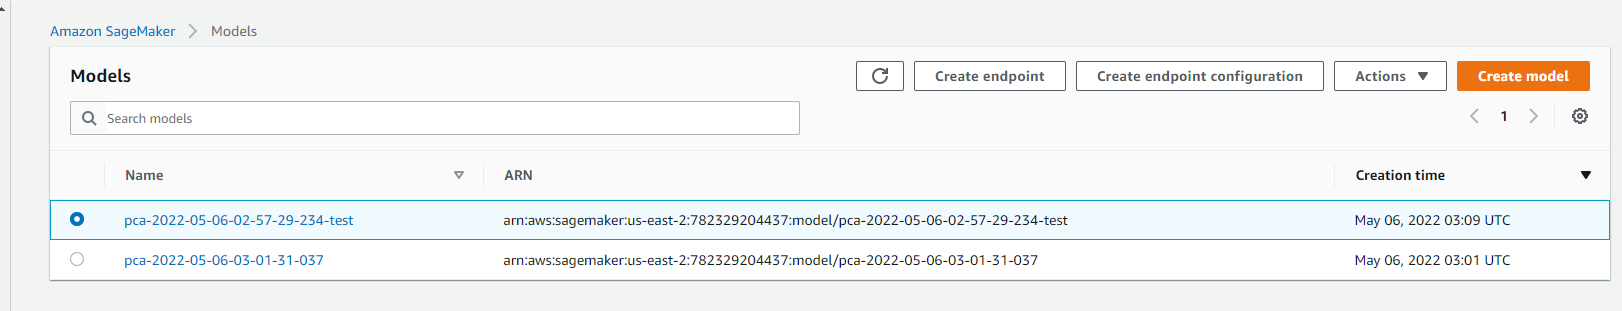

**Batch prediction PCA**

Now that our PCA training job has finished, let’s generate some predictions from it. We’ll start by creating a batch transformer. 

In [22]:
pca_transformer = pca.transformer(
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path="s3://{}/{}/pca/transform/train".format(bucket, prefix),
)

Now, we’ll pass our training data in to get predictions from batch transformer. A critical parameter to set properly here is split_type. Since we are using CSV, we’ll specify ‘Line’, which ensures we only pass one line at a time to our algorithm for prediction. Had we not specified this, we’d attempt to pass all lines in our file, which would exhaust our transformer instance’s memory.

**Note:** Here we pass the S3 path as input rather than input we use in ``.fit()``.

In [23]:
pca_transformer.transform(train_s3, content_type="text/csv", split_type="Line")
pca_transformer.wait()

................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/06/2022 03:06:51 INFO 140438325135168] loaded entry point class algorithm.serve.server_config:config_api
[05/06/2022 03:06:51 INFO 140438325135168] nvidia-smi: took 0.031 seconds to run.
[05/06/2022 03:06:51 INFO 140438325135168] nvidia-smi identified 0 GPUs.
[05/06/2022 03:06:51 INFO 140438325135168] loading entry points
[05/06/2022 03:06:51 INFO 140438325135168] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[05/06/2022 03:06:51 INFO 140438325135168] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[05/06/2022 03:06:51 INFO 140438325135168] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[05/06/2022 03:06:51 INFO 140438325135168] loaded request iterator application/json
[05/06/2022 03:

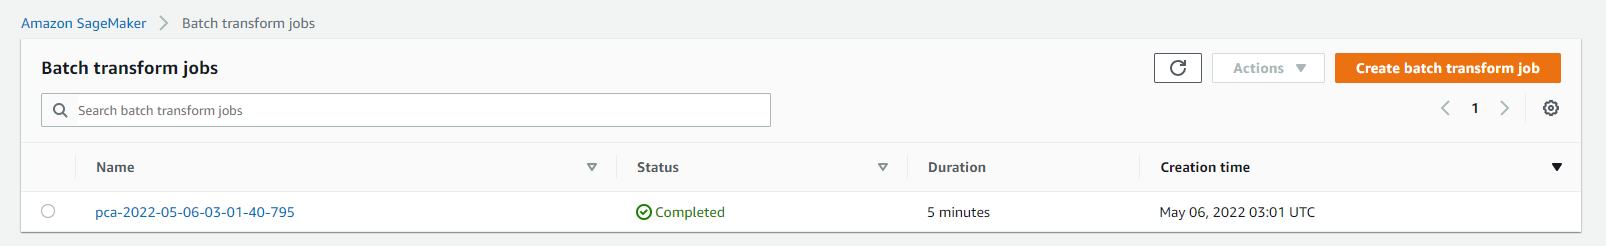

Now that our batch transform job has completed, let’s take a look at the output. Since we’ve reduced the dimensionality so much, the output is reasonably small and we can just download it locally.

**Real-time prediction comparison**

In [ ]:
pca_predictor = pca.deploy(
    initial_instance_count=1,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer(),
    instance_type="ml.m4.xlarge",
)

In [ ]:
components = []
for array in np.array_split(np.array(train_sparse.todense()), 500):
    result = pca_predictor.predict(array)
    components += [r["projection"] for r in result["projections"]]
components = np.array(components)

In [ ]:
sess.delete_endpoint(pca_predictor.endpoint)

**Batch prediction on new data**

In [28]:
pca_model = sess.create_model_from_job(pca._current_job_name, name="{}-test".format(pca._current_job_name))

Now, we can create a transformer starting from the SageMaker model. Our arguments are the same as when we created the transformer from the estimator except for the additional model name argument.

In [ ]:
pca_test_transformer = Transformer(
    pca_model,
    1,
    "ml.m4.xlarge",
    output_path="s3://{}/{}/pca/transform/test".format(bucket, prefix),
    sagemaker_session=sess,
    strategy="MultiRecord",
    assemble_with="Line",
)
pca_test_transformer.transform(test_s3, content_type="text/csv", split_type="Line")
pca_test_transformer.wait()

We can see that we have output the reduced dimensional components for our test dataset, using the model we built from our training dataset.

At this point in time, we’ve shown all of the batch functionality you need to get started using it in Amazon SageMaker.